In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

(2) Hydrogen VQE Example
========================

In [3]:
geo_file = "../h2.xyz"

symbols, coordinates = qml.qchem.read_structure(geo_file)
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

print("Number of qubits = ", qubits)

Number of qubits =  4


For our ansatz, we use the circuit from the [VQE
tutorial](https://pennylane.ai/qml/demos/tutorial_vqe.html) but expand
out the arbitrary single-qubit rotations to elementary gates (RZ-RY-RZ).


In [4]:
dev = qml.device("lightning.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)

def ansatz(params, wires=[0, 1, 2, 3]):
    # qml.BasisState(hf_state, wires=wires)
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

Note that the qubit register has been initialized to $|1100\rangle$,
which encodes for the Hartree-Fock state of the hydrogen molecule
described in the minimal basis. Again, we define the cost function to be
the following QNode that measures `expval(H)`:


In [5]:
exact_value = -1.136189454088

We now set up our optimizations runs.


In [6]:
@qml.qnode(dev)
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

In [7]:
############## Extracting Pauli observables from the Hamiltonian ##################

pauli_strings = [qml.grouping.pauli_word_to_string(P, wire_map=range(4)) for P in hamiltonian.ops]
N_A_pauli_word = [ob[1] + ob[3] for ob in pauli_strings]
u_obs_list = sorted(set(N_A_pauli_word)) # set of observables for uncut qubits

main_pauli_strings = pauli_strings.copy()

grouped_paulis = []   # Grouping of all the observables in the Hamiltonian
grouped_coeffs = []   # Grouping of all the coefficients in the Hamiltonian

u_grouped_paulis = [] # Grouping of Subcircuit_u observables in the Hamiltonian
v_grouped_paulis = [] # Grouping of Subcircuit_v observables in the Hamiltonian

H_coeff = hamiltonian.coeffs     # Hamoltonian coefficients
H_coeff = [float(c) for c in H_coeff]

for test in sorted(u_obs_list):
    tmp_ob = []
    tmp_coeff = []
    tmp_coeffs = []
    tmp_u = []
    tmp_v = []
    for i, word in enumerate(pauli_strings):
        if word[1] + word[3] == test:       # group observables based on the obserabes of A0 and A1
            tmp_ob.append(word)
            tmp_u.append(word[1] + word[3]) # extract observables for qubits labelled A0 and A1
            tmp_v.append(word[0] + word[2]) # extract observables for qubits labelled C0 and B0
            tmp_coeffs.append(H_coeff[i])
            tmp_coeff.append(float(H_coeff[i]))
    for j, k in zip(tmp_ob, tmp_coeff):
        pauli_strings.remove(j)
        H_coeff.remove(k)
        
    grouped_paulis.append(tmp_ob)
    grouped_coeffs.append(tmp_coeffs)
    u_grouped_paulis.append(tmp_u)  
    v_grouped_paulis.append(tmp_v) 

/home/gideonuchehara/anaconda3/envs/ricco/lib/python3.9/site-packages/pennylane/__init__.py:350: UserWarning: The qml.grouping module is deprecated, please use qml.pauli instead.
  warnings.warn(


In [8]:
##################### Defining Subcircuits ##################################


N_A_wires = 2
N_B_wires = 1
N_C_wires = 1


N_AB_wires = N_A_wires + N_B_wires            # subcircuit_AB total wires
N_BC_wires = N_B_wires + N_C_wires            # subcircuit_BC total wires
N_wires = N_A_wires + N_B_wires + N_C_wires   # total wires in circuit

# Generating labels for the differenct wires
A_wires = ["A" + str(x) for x in list(range(N_A_wires))]
B_wires = ["B" + str(x) for x in list(range(N_B_wires))]
C_wires = ["C" + str(x) for x in list(range(N_C_wires))]

# mapping the wires to their respective labels
A_wire_map = {x: idx for idx, x in enumerate(A_wires)}
B_wire_map = {x: idx for idx, x in enumerate(B_wires)}
C_wire_map = {x: idx for idx, x in enumerate(C_wires)}

# wire labels for the different subcircuits
AB_wires = [A_wires[0]] + B_wires + [A_wires[1]]             # subcircuit_AB wire labels
BC_wires = C_wires  + B_wires            # subcircuit_BC twire labels
all_wires = C_wires + AB_wires   # total wire labels

# wire mapping for the different subcircuits
AB_wires_map = {x: idx for idx, x in enumerate(AB_wires)}
BC_wires_map = {x: idx for idx, x in enumerate(BC_wires)}
all_wires_map = {x: idx for idx, x in enumerate(all_wires)}

# Generating and ordering Pauli group for N_B_wires
N_B_grouped = qml.grouping.partition_pauli_group(N_B_wires)
N_B_grouped_flat = [term for group in N_B_grouped for term in group]
N_B_order = qml.math.argsort(N_B_grouped_flat)
N_B_pauli_word = qml.math.array(N_B_grouped_flat)[N_B_order]
opt_pauli_string = [P for P in N_B_pauli_word if all( [c in set('IZ') for c in P])]

# Pauli I and Z and their respective eigenvectors and eigenvalues
I = ["0", "1"]                   # eigenvectors of I
I_sign = qml.math.array([1, 1])  # eigenvalues of I

Z = ["0", "1"]                   # eigenvectors of Z
Z_sign = qml.math.array([1, -1]) # eigenvalues of Z

meas_to_prep_state_dic = {"I":I, "Z":Z}           # Dictionary for eigenvectors
meas_to_prep_sign_dic = {"I":I_sign, "Z":Z_sign}  # Dictionary for eigenvalues

def observables_and_eigenvalues_u(obs):
    # Observable for the uncut qubits (A0 and A1) of subcircuit_u
    N_A_pauli_word = obs

    # Pauli strings for the subcircuit_u
    # sandwich qubit B0 between qubits A0 and A1
    AB_pauli_labels = [N_A_pauli_word[0] + word + N_A_pauli_word[1] for word in N_B_pauli_word]

    # convert the Pauli strings to Pauli observables mappped to the respective wires
    AB_paulis = [qml.grouping.string_to_pauli_word(P, wire_map=AB_wires_map) 
                  for P in AB_pauli_labels]

    # Paulis with only Z or I
    opt_paulis = [qml.grouping.string_to_pauli_word(P, wire_map=AB_wires_map) 
                  for P, B in zip(AB_pauli_labels, N_B_pauli_word) if 
                  all( [c in set('IZ') for c in B]
    )]

    eig_list = []
    for string in opt_pauli_string:
        eig = 0
        for indx, ob in enumerate(string):
            if indx==0:
                eig = meas_to_prep_sign_dic[ob]
            else:
                eig = qml.math.kron(eig, meas_to_prep_sign_dic[ob])
        eig_list.append(list(eig))

    eigvals = np.array(eig_list)
    
    return N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals


In [9]:
dev = qml.device("lightning.qubit", wires=all_wires)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
vqe_params = init_params

def modified_ansatz(vqe_params, wires=all_wires):
    # qml.BasisState(hf_state, wires=wires)
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[1])
    for i, j in enumerate(wires):
        qml.RZ(vqe_params[3 * i], wires=j)
        qml.RY(vqe_params[3 * i + 1], wires=j)
        qml.RZ(vqe_params[3 * i + 2], wires=j)
    qml.CNOT(wires=[wires[2], wires[3]])
    
    qml.WireCut(wires=wires[2])
    
    qml.CNOT(wires=[wires[2], wires[0]])
    qml.CNOT(wires=[wires[3], wires[1]])
    

@qml.qnode(dev)
def modified_cost(_vqe_params):
    modified_ansatz(_vqe_params, wires=all_wires)
    return qml.expval(modified_hamiltonian)

In [10]:
wires_map = {i:j for i,j in zip(range(N_wires), all_wires)}

wires_AB_map = {key: value for key,value in wires_map.items() if ('A' in value or 'B' in value)}

wires_BC_map = {key: value for key,value in wires_map.items() if ('C' in value)}

In [11]:
import copy
def map_wires(H, wires_map):
    """Map the wires of an Observable according to a wires map.
    
    Args:
        H (Hamiltonian or Tensor or Observable): Hamiltonian to remap the wires of.
        wires_map (dict): Wires map with `(origin, destination)` pairs as key-value pairs.
    
    Returns:
        Hamiltonian or Tensor or Observable: A copy of the original Hamiltonian with remapped wires.
    """
    if isinstance(H, qml.Hamiltonian):
        new_ops = [map_wires(op, wires_map) for op in H.ops]
        new_H = qml.Hamiltonian(H.coeffs, new_ops)
    elif isinstance(H, qml.operation.Tensor):
        new_obs = [map_wires(ob, wires_map) for ob in H.obs]
        new_H = qml.operation.Tensor(*new_obs)
    elif isinstance(H, qml.operation.Observable):
        new_H = copy.copy(H)
        new_H._wires = new_H.wires.map(wires_map)
        
    return new_H

modified_hamiltonian = map_wires(hamiltonian, wires_map)

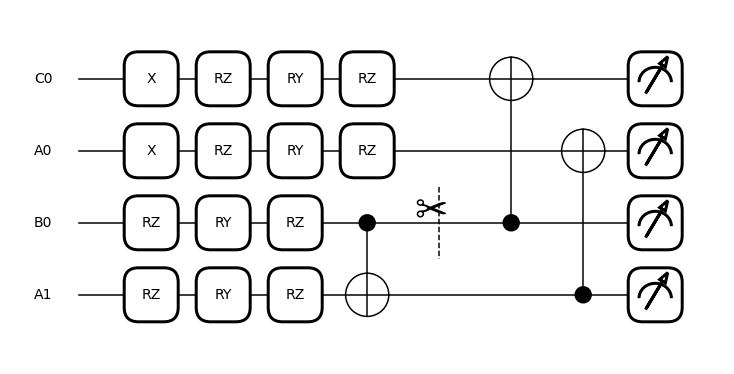

In [12]:
qml.drawer.use_style('black_white')
fig, _ = qml.draw_mpl(modified_cost)(vqe_params)
# fig.set_size_inches(12,6)
plt.rc('font', size=100)
plt.rcParams['text.color'] = 'maroon'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['patch.linewidth'] = 30
# plt.savefig("full_circuit.svg")
plt.savefig("full_circuit.pdf")

In [13]:
def main_and_v_observables(obs):
    """
    return the observables for subcircuit_v and the observable for the entire circuit
    """
    # Pauli strings for qubits B0 and C0 of subcircuits_v
    N_BC_pauli_word = obs[0] + obs[2]
    BC_pauli_labels = [N_BC_pauli_word]

    BC_paulis = [qml.grouping.string_to_pauli_word(P, wire_map=BC_wires_map) 
                      for P in BC_pauli_labels]

    op = qml.grouping.string_to_pauli_word(obs, wire_map=all_wires_map)
    return BC_paulis, BC_pauli_labels, op

In [14]:
def vqe_template_AB(vqe_params, wires=AB_wires):
    qml.PauliX(wires=wires[0])
    for i, j in wires_AB_map.items():
        qml.RZ(vqe_params[3 * i], wires=j)
        qml.RY(vqe_params[3 * i + 1], wires=j)
        qml.RZ(vqe_params[3 * i + 2], wires=j)
    qml.CNOT(wires=[wires[1], wires[2]])
    
    qml.CNOT(wires=[wires[2], wires[0]])

In [15]:
def vqe_template_BC(vqe_params, wires=BC_wires):
    qml.PauliX(wires=wires[0])
    for i, j in wires_BC_map.items():
        qml.RZ(vqe_params[3 * i], wires=j)
        qml.RY(vqe_params[3 * i + 1], wires=j)
        qml.RZ(vqe_params[3 * i + 2], wires=j)
    
    qml.CNOT(wires=[wires[1], wires[0]])

In [16]:
# Unitary operator to be used at cut location for one qubit cut
def one_qubit_unitary(ricco_params, wires):
    """Ansatz for a general two-qubit unitary V."""
    qml.Rot(*ricco_params, wires=B_wires)

# Conjugate of Unitary operator to be used at cut location for one qubit cut
def one_qubit_unitary_dagger(ricco_params, wires):
    """Ansatz for a general two-qubit unitary V."""
    qml.adjoint(one_qubit_unitary)(ricco_params, wires)

In [17]:
def quantum_function_for_AB(vqe_params, ricco_params):
    vqe_template_AB(vqe_params) # Using optimal_params for template cct.
    # one_qubit_unitary(ricco_params, wires=B_wires)
    
def quantum_function_for_BC(vqe_params, ricco_params):
    # one_qubit_unitary_dagger(ricco_params, wires=B_wires)
    vqe_template_BC(vqe_params) # Using optimal_params for template cct.

In [18]:
# Defining the first half of the cut circuit - Subcircuit_AB
dev = qml.device("lightning.qubit", wires=AB_wires)
# Define ricco Parameters
ricco_params = np.random.uniform(-np.pi, np.pi, size=4**N_B_wires-1)
    
@qml.qnode(dev)
def subcircuit_for_AB(vqe_params, ricco_params, opt_paulis):
    quantum_function_for_AB(vqe_params, ricco_params)
    return [qml.expval(P) for P in opt_paulis]

@qml.qnode(dev)
def subcircuit_for_test(vqe_params, ricco_params, AB_paulis):
    quantum_function_for_AB(vqe_params, ricco_params)
    return [qml.expval(P) for P in AB_paulis]

In [19]:
# intentionally did this for variables  BC_paulis, op
bc_and_all_obs = []
for group in grouped_paulis:
    tmp_group = []
    for obs in group:
        BC_paulis, BC_pauli_labels, op = main_and_v_observables(obs)
        tmp_group.append([BC_paulis, BC_pauli_labels, op])
    bc_and_all_obs.append(tmp_group)

In [20]:
# intentionally did this for variables  AB_paulis, opt_paulis
opt_list = []
for obs in u_obs_list:
    N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals = \
                                                        observables_and_eigenvalues_u(obs)
    opt_list.append([N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals])

In [21]:
N_A_pauli_word, AB_paulis, AB_pauli_labels, opt_paulis, eigvals = opt_list[0]
BC_paulis, BC_pauli_labels, op = bc_and_all_obs[0][0]

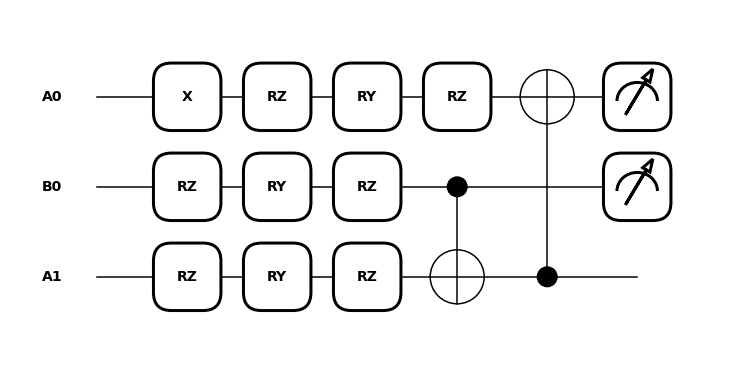

In [22]:
qml.drawer.use_style('black_white')
fig, _ = qml.draw_mpl(subcircuit_for_AB)(vqe_params, ricco_params, opt_paulis)
fig.set_size_inches(10,5)
# plt.rc('font', size=100)
plt.rcParams['text.color'] = 'maroon'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['patch.linewidth'] = 30
# plt.savefig("upstream.svg")
plt.savefig("upstream.pdf")

In [23]:
# Defining the second half of the cut circuit - Subcircuit_BC
dev = qml.device("lightning.qubit", wires=BC_wires)
    
@qml.qnode(dev)
def subcircuit_for_BC(vqe_params, ricco_params, BC_paulis):
    quantum_function_for_BC(vqe_params, ricco_params)
    return [qml.expval(P) for P in BC_paulis]

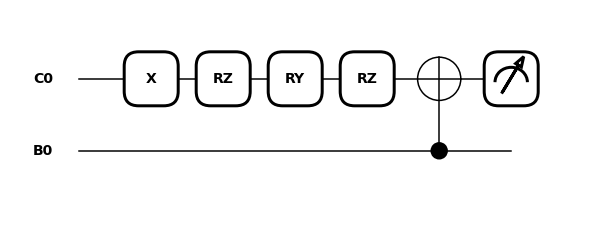

In [24]:
qml.drawer.use_style('black_white')
fig, _ = qml.draw_mpl(subcircuit_for_BC)(vqe_params, ricco_params, BC_paulis)
# fig.set_size_inches(12,5)
plt.rc('font', size=100)
plt.rcParams['text.color'] = 'maroon'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['patch.linewidth'] = 30
# plt.savefig("downstream.svg")
plt.savefig("downstream.pdf")